In [1]:
# Import Librabries
import numpy as np
import pandas as pd
import keras        # pip install keras==2.8.0
import cv2
from matplotlib import pyplot as plt
import os
import random
from PIL import Image

In [2]:
df = pd.read_csv("train.csv")
base_path ="./images/"

In [3]:
df

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7
...,...,...
1580465,72c3b1c367e3d559,203092
1580466,7a6a2d9ea92684a6,203092
1580467,9401fad4c497e1f9,203092
1580468,aacc960c9a228b5f,203092


In [4]:
samples = 20000
df = df.loc[df["id"].str.startswith('00', na=False), :]
num_classes = len(df["landmark_id"].unique())
num_data = len(df)

In [5]:
num_classes

5346

In [6]:
num_data

6120

In [7]:
data = pd.DataFrame(df["landmark_id"].value_counts())

data.reset_index(inplace=True)
data.head()

,index,landmark_id
0,138982,31
1,83144,14
2,126637,7
3,194914,7
4,109169,6


In [8]:
data.tail()

,index,landmark_id
5341,71434,1
5342,71336,1
5343,71228,1
5344,71145,1
5345,202981,1


In [9]:
data.columns=['landmark_id','count']


In [10]:
data['count'].describe()

count    5346.000000
mean        1.144781
std         0.641260
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        31.000000
Name: count, dtype: float64

(array([5.344e+03, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

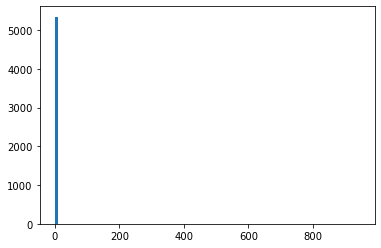

In [11]:
plt.hist(data['count'], 100, range = (0,32), label = 'test')

In [12]:
data['count'].between(0,5).sum()

5339

In [13]:
data['count'].between(5,10).sum()

14

(array([2., 1., 1., ..., 1., 1., 2.]),
 array([    27,     60,    124, ..., 202950, 202972, 202981], dtype=int64),
 <BarContainer object of 5345 artists>)

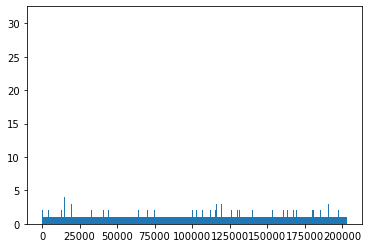

In [14]:
plt.hist(df["landmark_id"],bins=df["landmark_id"].unique())

In [15]:
# Training of Model
from sklearn.preprocessing import LabelEncoder
lencoder = LabelEncoder()
lencoder.fit(df["landmark_id"])

LabelEncoder()

In [16]:
df.head()

,id,landmark_id
119,00cba0067c078490,27
120,00f928e383e1d121,27
796,009ecdb56b5e9adb,60
1089,00d5d47528839144,124
1133,00e9003a381ab809,134


In [17]:
def encode_label(lbl):
    return lencoder.transform(lbl)

In [18]:
def decode_label(lbl):
    return lencoder.inverse_transform(lbl)

In [48]:
def get_image_from_number(num, df):
    fname, label = df.iloc[num, :]
    fname = fname + '.jpg'
    f1 = fname[0]
    f2 = fname[1]
    f3 = fname[2]
    path = os.path.join(f1,f2,f3,fname)
    im = cv2.imread(os.path.join(base_path, path))
    return im, label

4 Sample images from random classes


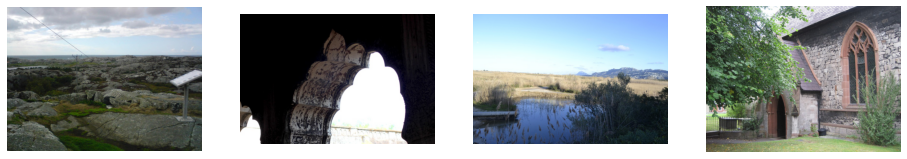

In [20]:
print("4 Sample images from random classes")
fig = plt.figure(figsize=(16,16))
for i in range(1,5):
    ri = random.choices(os.listdir(base_path), k=3)
    folder = base_path + '/' + ri[0] + '/' + ri[1] + '/' + ri[2]
    random_img = random.choice(os.listdir(folder))
    img = np.array(Image.open(folder+'/'+random_img))
    fig.add_subplot(1,4,i)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [21]:
from keras.applications.vgg19 import VGG19
from keras.layers import *
from keras import Sequential
tf.compat.v1.disable_eager_execution()

In [22]:
# Parameters
learning_rate = 0.0001
decay_speed   = 1e-6
momemtum      = 0.09
loss_function = "sparse_categorical_crossentropy"
source_model  = VGG19(weights=None)
drop_layer    = Dropout(0.5)
drop_layer2   = Dropout(0.5)

In [23]:
model = Sequential()
for layer in source_model.layers[:-1]:
    if layer == source_model.layers[-25]:
        model.add(BatchNormalization())
    model.add(layer)
model.add(Dense(num_classes, activation = "softmax"))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 224, 224, 3)      12        
 ormalization)                                                   
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)

In [24]:
optim1 = keras.optimizer_v1.RMSprop(lr = learning_rate)
model.compile(optimizer=optim1,
             loss=loss_function,
             metrics = ["accuracy"])

In [25]:
def image_reshape(im, target_size):
    return cv2.resize(im, target_size)

In [26]:
def get_batch(dataframe, start, batch_size):
    image_array = []
    label_array = []
    
    end_img = start+batch_size
    if(end_img) > len(dataframe):
        end_img = len(dataframe)
    
    for idx in range(start, end_img):
        n = idx
        im, label = get_image_from_number(n, dataframe)
        im = image_reshape(im, (224, 224)) / 255.0
        image_array.append(im)
        label_array.append(label)
    
    label_array = encode_label(label_array)
    
    return np.array(image_array), np.array(label_array)

In [27]:
batch_size = 16
epoch_shuffle = True
weight_classes = True
epochs = 1

# split
train, val = np.split(df.sample(frac=1),[int(0.8*len(df))])
print(len(train))
print(len(val))

4896
1224


In [28]:
for e in range(epochs):
    print("Epoch :" + str (e+1) + "/"+ str(epochs))
    if epoch_shuffle:
        train = train.sample(frac = 1)
    for it in range(int(np.ceil(len(train)/batch_size))):
        X_train, y_train = get_batch(train, it*batch_size, batch_size)
        
        model.train_on_batch(X_train, y_train)
        
model.save("Model")

Epoch :1/1
INFO:tensorflow:Assets written to: Model\assets


In [31]:
# Test
batch_size = 16

errors = 0
good_preds = []
bad_preds = []


for it in range(int(np.ceil(len(val)/batch_size))):
    X_val, y_val = get_batch(val, it*batch_size, batch_size)
    
    result = model.predict(X_val)
    cla = np.argmax(result, axis=1)
    for idx, res in enumerate(result):
        if cla[idx] != y_val[idx]:
            errors = errors + 1
            bad_preds.append([batch_size*it + idx, cla[idx], res[cla[idx]]])
        else:
            good_preds.append([batch_size*it + idx, cla[idx], res[cla[idx]]])



In [38]:
good_preds = np.array(good_preds)
good_preds = np.array(sorted(good_preds, key = lambda x: x[2], reverse=True))

array([[3.31000000e+02, 3.63600000e+03, 1.93062602e-04],
       [9.19000000e+02, 3.63600000e+03, 1.93062602e-04],
       [7.70000000e+02, 3.63600000e+03, 1.93062544e-04],
       [1.10500000e+03, 3.63600000e+03, 1.93062529e-04],
       [7.55000000e+02, 3.63600000e+03, 1.93062515e-04],
       [8.87000000e+02, 3.63600000e+03, 1.93062369e-04]])

In [ ]:
fig=plt.figure(figsize=(16, 16))
for i in range(1,6):
    n = int(good_preds[i,0])
    img, lbl = get_image_from_number(n, val)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig.add_subplot(1, 5, i)
    plt.imshow(img)
    lbl2 = np.array(int(good_preds[i,1])).reshape(1,1)
    sample_cnt = list(df.landmark_id).count(lbl)
    plt.title("Label: " + str(lbl) + "\nClassified as: " + str(decode_label(lbl2)) + "\nSamples in class " + str(lbl) + ": " + str(sample_cnt))
    plt.axis('off')
plt.show()